In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns
import torch.nn as nn
import torch
import os
#import math
#import pandas as pd
#from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
import pickle
import torchvision
from torch.optim import SGD, Adam
from crp.image import imgify, vis_opaque_img, plot_grid

#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
#from torch.autograd import Variable

from tqdm import tqdm 

import tigramite
from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [2]:
class DSpritesImageDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.train = train
        self.transform = transform
        self.img_dir = "dsprites-dataset/images/"
        with open('labels.pickle', 'rb') as f:
            labels = pickle.load(f)
            self.labels = labels
        #dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',encoding='bytes', allow_pickle=True)
        #self.metadata = dataset_zip['metadata'][()]
        #self.latents_values = dataset_zip['latents_values']
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, f'{index}.npy')
        image = np.load(img_path)
        image = torch.from_numpy(np.asarray(image, dtype=np.float32)).view(1,64,64)
        target = self.labels[index][1]
        # use actual numerical value instead
        # target = float(metadata["latents_possible_values"]["orientation"][target])
        # use one-hot-encoding
        # target = one_hot(target)
        if not self.train:
            return (image, target, index)
        return (image, target)


In [3]:
BATCH_SIZE = 128
dsprites_dataset = DSpritesImageDataset() # set train=False if you want indices
dsprites_dataset, dsprites_dataset_test =  random_split(dsprites_dataset, [0.3,0.7])

training_loader = DataLoader(dsprites_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dsprites_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

dsprites_dataset_ci = DSpritesImageDataset(train=False) 
ci_loader = DataLoader(dsprites_dataset_ci, batch_size=BATCH_SIZE, shuffle=True)


In [5]:
class ShapeConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ShapeConvolutionalNeuralNetwork, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=9, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(8, 8, kernel_size=9, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(288, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
model = ShapeConvolutionalNeuralNetwork()
model.eval()
dataiter = iter(training_loader)
images, labels = next(dataiter)
res = model(images)
print(res.data.max(1, keepdim=True)[1].flatten(), labels, images.shape)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]) tensor([2, 2, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2,
        2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 0, 1,
        1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 2, 1, 0,
        2, 0, 0, 2, 2, 1, 2, 1, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 2, 2, 2, 1, 2, 0,
        1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1,
        2, 0, 2, 0, 1, 0, 0, 1]) torch.Size([128, 1, 64, 64])


In [29]:
# only needed for retraining     
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.4)

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    correct = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in (pbar := tqdm(enumerate(training_loader))):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            nccorrect = correct / (BATCH_SIZE)
            pbar.set_description('  batch {} correct {}%'.format(i + 1, np.round(nccorrect,2)))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.
            correct = 0

    return last_loss

In [30]:
def train_network():
    epoch_number = 0
    EPOCHS = 3
    best_vloss = 1_000_000.
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number)   
        # save the model's state
        model_path = 'model_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

        epoch_number += 1


#train_network()

EPOCH 1:


  batch 1700 correct 38.3%: : 1729it [01:39, 17.29it/s] 


EPOCH 2:


  batch 1700 correct 72.25%: : 1729it [01:26, 20.06it/s]


EPOCH 3:


  batch 1700 correct 98.04%: : 1729it [01:25, 20.26it/s]


In [7]:
PATH = "model_dsprites.pickle"
#torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

fv_path = "crp-stuff/dsprites"
fv = FeatureVisualization(attribution, dsprites_dataset, layer_map, path=fv_path)
layer_names

NameError: name 'model' is not defined

In [9]:
index = 10
datum = dsprites_dataset[index]
label = datum[1]
img = datum[0]
sample = img.view(1,1,64,64)
sample.requires_grad = True
cond_layer = 'convolutional_layers.3'

conditions = [{'y': [label]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
pred = attr.prediction.max(1, keepdim=True)[1]

rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
# the ten most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(f'label {label},prediction:{pred[0][0]} top 6 concepts: {concept_ids}, their relevances: {rel_values*100}')
#conditions = [{cond_layer: [id], 'y': [label]} for id in concept_ids]
#heatmap, a, b, c = attribution(sample, conditions, composite)
#imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)),resize=700)
plt.imshow(img[0], cmap="Greys")

NameError: name 'attribution' is not defined

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/attribution.py:155: UserWarning: You defined a condition for y that has no effect, since the 'start_layer' linear_layers.0 is provided where the backward pass begins. If this behavior is not wished, remove 'start_layer'.
  warnings.warn(
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


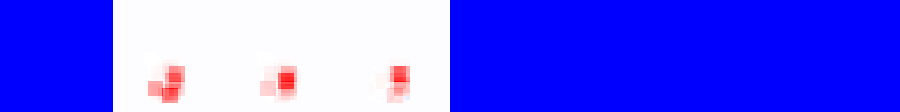

In [23]:
cond_layer,n_c = "convolutional_layers.3",8
start_layer,n_s = "linear_layers.0",8

conditions = [
    {"y": [label], cond_layer: [j]}  for j in range(n_c)
] 
attr = attribution(
    sample,
    conditions,
    composite,
    record_layer=layer_names,
    start_layer=start_layer,
)

imgify(attr.heatmap, resize=900, grid=(1, n_c), symmetric=True)


In [12]:
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]

In [39]:
def get_top_k_neurons(img, label, layer, neurons, k=10):
    top_k_per_neuron = []
    for neuron in neurons:
        conditions = [{cond_layer: [neuron], 'y': [label]}]
        attr = attribution(img, conditions, composite, record_layer=layer_names)
        rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
        rel_values, concept_ids = torch.topk(rel_c[0], 10)
        print(concept_ids)
        top_k_per_neuron.append(concept_ids)
    return np.array(top_k_per_neuron, dtype=np.int32)

In [40]:
pool_img = torch.nn.MaxPool2d(4, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

def make_reduced_heatmap(img,conditions):
    attr = attribution(img, conditions, composite, record_layer=layer_names)

    if np.count_nonzero(attr.heatmap) == 0:
        print("is empty", conditions)
    hmap = attr.heatmap[:, 4:, 4:]
    #print(hmap.shape)
    hmap = hmap[:,:56, :56]
    #print(hmap.shape)
    hmap = pool_img(hmap)
    hmap = hmap.view(hmap.size(0), -1)
    return hmap
    

def get_heatmaps(img, label, layer, neurons):
    heatmaps = np.empty((len(neurons)+1, 196))
    heatmaps[0] = make_reduced_heatmap(img, [{'y': [label]}])
    i = 1
    for neuron in neurons:
        conditions = [{cond_layer: [neuron], 'y': [label]}]
        heatmaps[i] = make_reduced_heatmap(img,conditions)
        i += 1
    return heatmaps

In [41]:
def draw_heatmaps_values(size,cond_layer,neurons, shape):
    samples = []
    dataiter = iter(test_loader)
    for blub in range(size):
        images, labels, indices = next(dataiter)
        images = images.view((BATCH_SIZE, 1,64,64))
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            if isinstance(shape, int) and label != shape:
                continue
            sample = images[i].view(1,1,64,64)
            sample.requires_grad = True
            # add heatmaps for neurons + label
            in_variables = get_heatmaps(sample, label, cond_layer, neurons)
            if not np.all(np.isfinite(in_variables)):
                print(i)
            samples.append(in_variables)
    return np.array(samples, dtype=np.float64)


In [42]:
from crp.cache import ImageCache

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="dsrpites-cache")

fv = FeatureVisualization(attribution, dsprites_dataset, layer_map, path=fv_path, cache=cache)

In [48]:
from crp.helper import get_output_shapes
import numpy as np

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=False,alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


Layer: convolutional_layers.3


100%|██████████| 8/8 [00:00<00:00, 11.93it/s]


Layer: linear_layers.0


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


Layer: linear_layers.2


100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


In [13]:
def draw_top_references():
    data = np.zeros((10,74,784))
    var_names = []
    for k,v in layer_id_map.items(): 
        ref_c = fv.get_max_reference(v, k, "relevance", (0, 10), plot_fn=vis_simple)
        for i, neur in  enumerate(ref_c.values()):
            for obs, ref_sample in enumerate(neur): 
                flat_img = np.array(ref_sample, dtype=np.float64).flatten()
                data[obs] += flat_img
            var_names += [f'{k}_{i}']
    dataframe = pp.DataFrame(np.array(data, dtype=np.float64), var_names=var_names, analysis_mode="multiple")
    return dataframe
#dataframe = draw_top_references()

In [14]:
def draw_reference_score_values(size,cond_layer,neurons):
    variables = []
    dataiter = iter(test_loader)
    for blub in range(size):
        images, labels = next(dataiter)
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            img = images[i]
            sample = img.view(1,1,64,64)
            sample.requires_grad = True
            #output = model(sample)
            #pred = output.data
            #prediction = list(pred[:][0])
            #in_variables = prediction
            # add relevance scores for neurons 
            res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables = res
            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
    return np.array(variables, dtype=np.float64)

def draw_complete_ref_score_values(size,layers, shape=None):
    variables = []
    dataiter = iter(test_loader)
    while len(variables) < size:
        images, labels = next(dataiter)
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            if shape is not None and label != shape:
                continue
            img = images[i]
            sample = img.view(1,1,64,64)
            sample.requires_grad = True 
            in_variables = []
            for x in layers:
                cond_layer = x[0]
                if cond_layer == "prediction":
                    output = model(sample)
                    pred = output.data
                    res = list(pred[:][0])
                else:
                    neurons = x[1]
                    res = get_reference_scores(sample, label, cond_layer, neurons)
                in_variables += res

            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
            if len(variables) == size:
                break
    return np.array(variables, dtype=np.float64)

In [115]:
def create_dataframe(cond_layer, neurons, size=2):
    neuron_names = [f"{cond_layer[0:4]}{cond_layer[-1]}_{k}" for k in neurons]
    class_names = [f"class_{i}" for i in range(10)]
    var_names = neuron_names  # class_names +
    # choose from functions: draw_top_k_references_values, draw_heatmaps_values,  draw_reference_score_values
    data = draw_reference_score_values(size, cond_layer, neurons)
    print(data.shape)
    # sanity test that variable names are correct
    print(
        f"number of intended variables: {len(var_names)}, actual number: {len(data[0])}, length of dataset: {len(data)}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names

In [15]:
def create_complete_df(layers, shape=None):
    var_names = np.array([
        f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]
    ])
    data = draw_complete_ref_score_values(600, layers, shape)
    print(
        f"number of intended variables: {var_names.shape}, shape of dataset: {data.shape}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names

def no_constants_df(layers, shape=None):
    all_var_names = np.array([
        f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]
    ])
    data = draw_complete_ref_score_values(1000, layers, shape)
    empty_vars = np.where(~data.any(axis=0))
    print(empty_vars)
    data = np.delete(data, empty_vars, axis=1)
    var_names = np.delete(all_var_names, empty_vars)
    layers = [
        [nam[0], [k for k in nam[1] if f"{nam[0][0:4]}{nam[0][-1]}_{k}" in var_names]] for nam in layers
    ]
    # sanity test that variable names are correct
    print(
        f"all variables: {all_var_names.shape},\n non-constant variables: {var_names.shape}, \n shape of dataset: {data.shape} \n new layers: \n{layers}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names, layers

In [16]:
def make_nn_link_assumptions(layers, same_layer=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer:
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                for other_neuron in layers[l + 1][1]:
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "-?>"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "<?-"
                index += 1
    return link_assumptions

In [17]:
# here you can use all existing layers and accordingly the set of neurons
layers = [["convolutional_layers.0",range(8)], ["convolutional_layers.3",range(8)], ["linear_layers.0",range(8)], ["prediction", range(3)]] # , ["prediction", range(3)]

dataframe,var_names, layers = no_constants_df(layers)


(array([ 3,  4,  5, 12, 13, 14]),)
all variables: (27,),
 non-constant variables: (21,), 
 shape of dataset: (1000, 21) 
 new layers: 
[['convolutional_layers.0', [0, 1, 2, 6, 7]], ['convolutional_layers.3', [0, 1, 2, 3, 7]], ['linear_layers.0', [0, 1, 2, 3, 4, 5, 6, 7]], ['prediction', [0, 1, 2]]]


In [20]:
#ci_test = CMIknn(significance='fixed_thres', fixed_thres=0.01)
ci_test = RobustParCorr(significance="analytic")
#ci_test = GPDCtorch()
#ci_test = CMIsymb(significance='fixed_thres', fixed_thres=0.4)
#ci_test = RegressionCI(significance='analytic')
link_assumptions  = make_nn_link_assumptions(layers, False)

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)

results = pcmci.run_pcmciplus(
    tau_max=0, pc_alpha=0.01, link_assumptions=link_assumptions
)


In [21]:
import networkx as nx


def plot_multipartite(graph_res, layers):
    link_matrix_upper = np.copy(graph_res["graph"])
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])
    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)
    node_labels = {}
    for i in G.nodes:
        n = 0
        if i < len(layers[0][1]):
            subset = 0
            layer = "convolutional_layers.0"
            n = i
        elif i < len(layers[0][1]) + len(layers[1][1]):
            subset = 1
            layer = "convolutional_layers.3"
            n = i - len(layers[0][1])
        elif i < len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]):
            subset = 2
            layer = "linear_layers.0"
            n = i - (len(layers[0][1]) + len(layers[1][1]))
        else:
            subset = 3
            layer = "prediction"
            n = i - (len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]))
        G.nodes[i]["subset"] = subset
        G.nodes[i]["layer"] = layer
        G.nodes[i]["name"] = layers[subset][1][n]
        node_labels[i] = f"{layer[:3]}{layer[-1]}_{layers[subset][1][n]}"
    print(G.nodes(data=True))
    pos = nx.multipartite_layout(G, subset_key="subset")
    edge_color = [results["val_matrix"][i][j][0] for (i, j) in G.edges]
    """ node_pos = {"x": [], "y": []}
    for n in pos.keys():
        node_pos["x"] += [pos[n][0]]
        node_pos["y"] += [pos[n][1]]
    tp.plot_graph(
        graph=results["graph"],
        val_matrix=results["val_matrix"],
        save_name=None,
        var_names=var_names,
        figsize=(20, 6),
        arrow_linewidth=4,
        arrowhead_size=30,
        node_size=0.1,
        node_aspect=1,
        label_fontsize=16,
        node_pos=node_pos,
        show_colorbar=False,
    )
    plt.show() """
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        labels=node_labels,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    ) 

[(0, {'subset': 0, 'layer': 'convolutional_layers.0', 'name': 0}), (1, {'subset': 0, 'layer': 'convolutional_layers.0', 'name': 1}), (2, {'subset': 0, 'layer': 'convolutional_layers.0', 'name': 2}), (3, {'subset': 0, 'layer': 'convolutional_layers.0', 'name': 6}), (4, {'subset': 0, 'layer': 'convolutional_layers.0', 'name': 7}), (5, {'subset': 1, 'layer': 'convolutional_layers.3', 'name': 0}), (6, {'subset': 1, 'layer': 'convolutional_layers.3', 'name': 1}), (7, {'subset': 1, 'layer': 'convolutional_layers.3', 'name': 2}), (8, {'subset': 1, 'layer': 'convolutional_layers.3', 'name': 3}), (9, {'subset': 1, 'layer': 'convolutional_layers.3', 'name': 7}), (10, {'subset': 2, 'layer': 'linear_layers.0', 'name': 0}), (11, {'subset': 2, 'layer': 'linear_layers.0', 'name': 1}), (12, {'subset': 2, 'layer': 'linear_layers.0', 'name': 2}), (13, {'subset': 2, 'layer': 'linear_layers.0', 'name': 3}), (14, {'subset': 2, 'layer': 'linear_layers.0', 'name': 4}), (15, {'subset': 2, 'layer': 'linear_lay

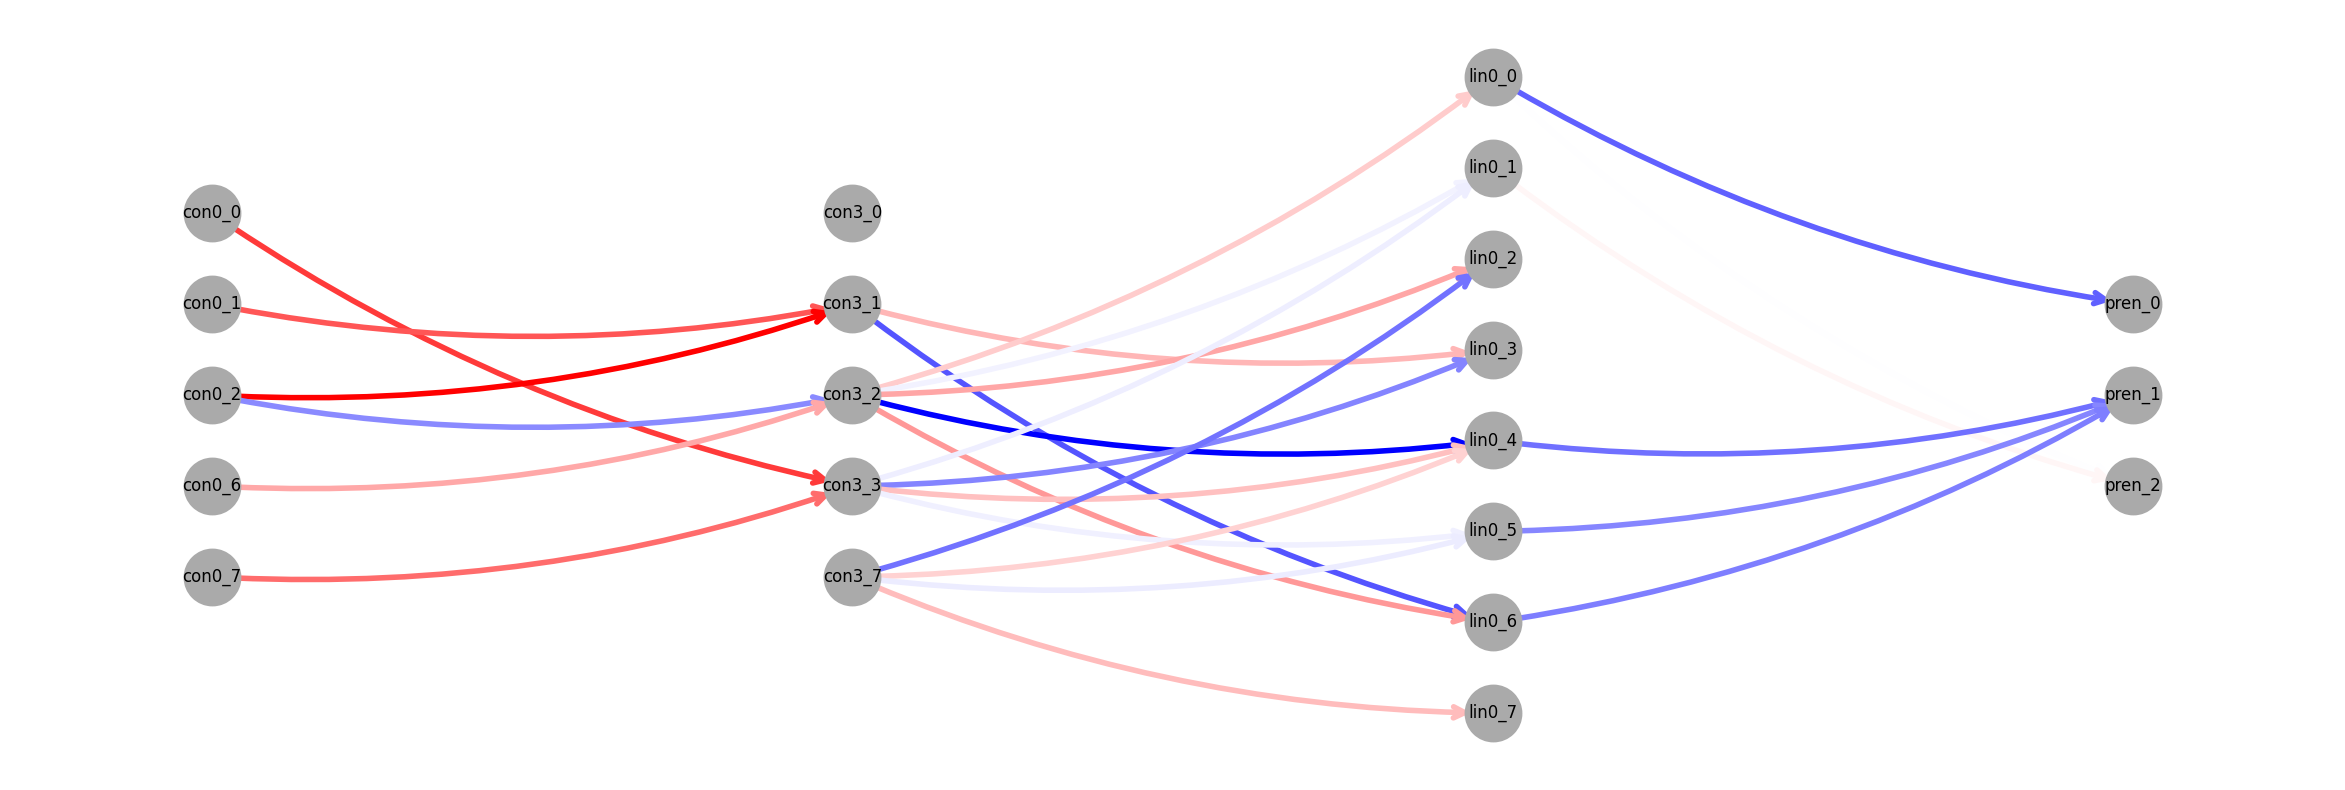

In [22]:

plot_multipartite(results, layers)


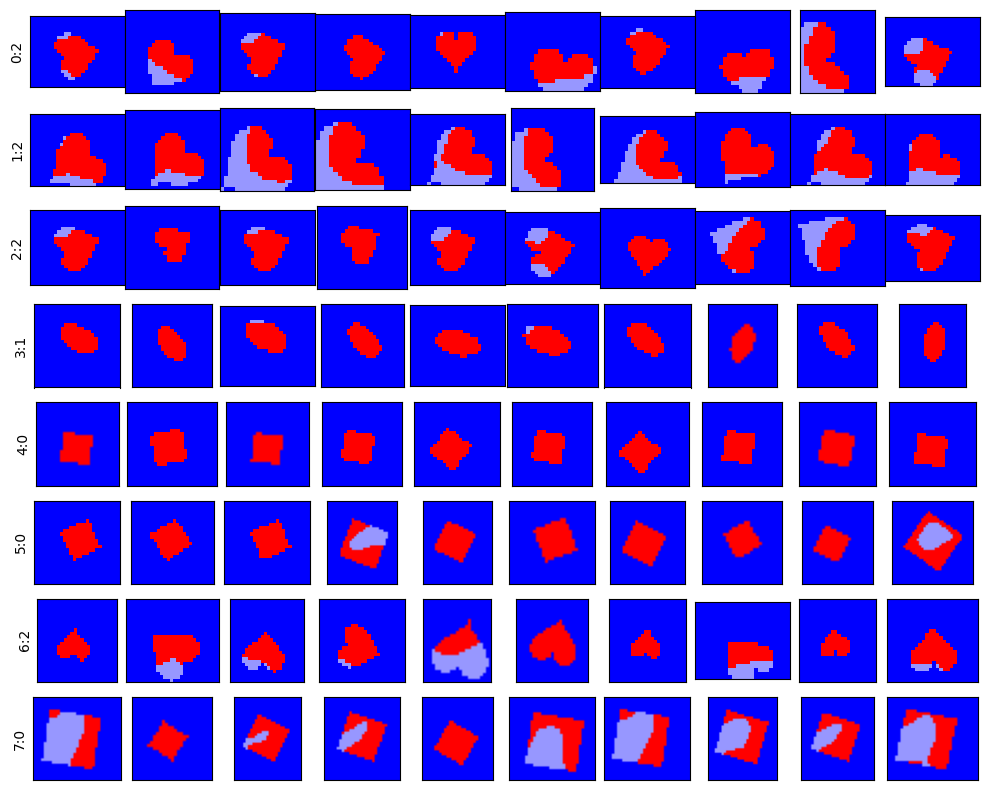

In [171]:
#cond_layer, neurons = "convolutional_layers.3",range(8) 
cond_layer, neurons = "linear_layers.0", range(8) 

all_refs = {}
for i in neurons:
    targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
    ref_c = fv.get_stats_reference(i, cond_layer,[targets], "relevance", (0, 10), composite=composite,rf=True, plot_fn=vis_opaque_img)
    all_refs[f'{i}:{targets}'] = ref_c[f'{i}:{targets}']
plot_grid(all_refs, figsize=(10, len(neurons)), padding=False, symmetric=True)

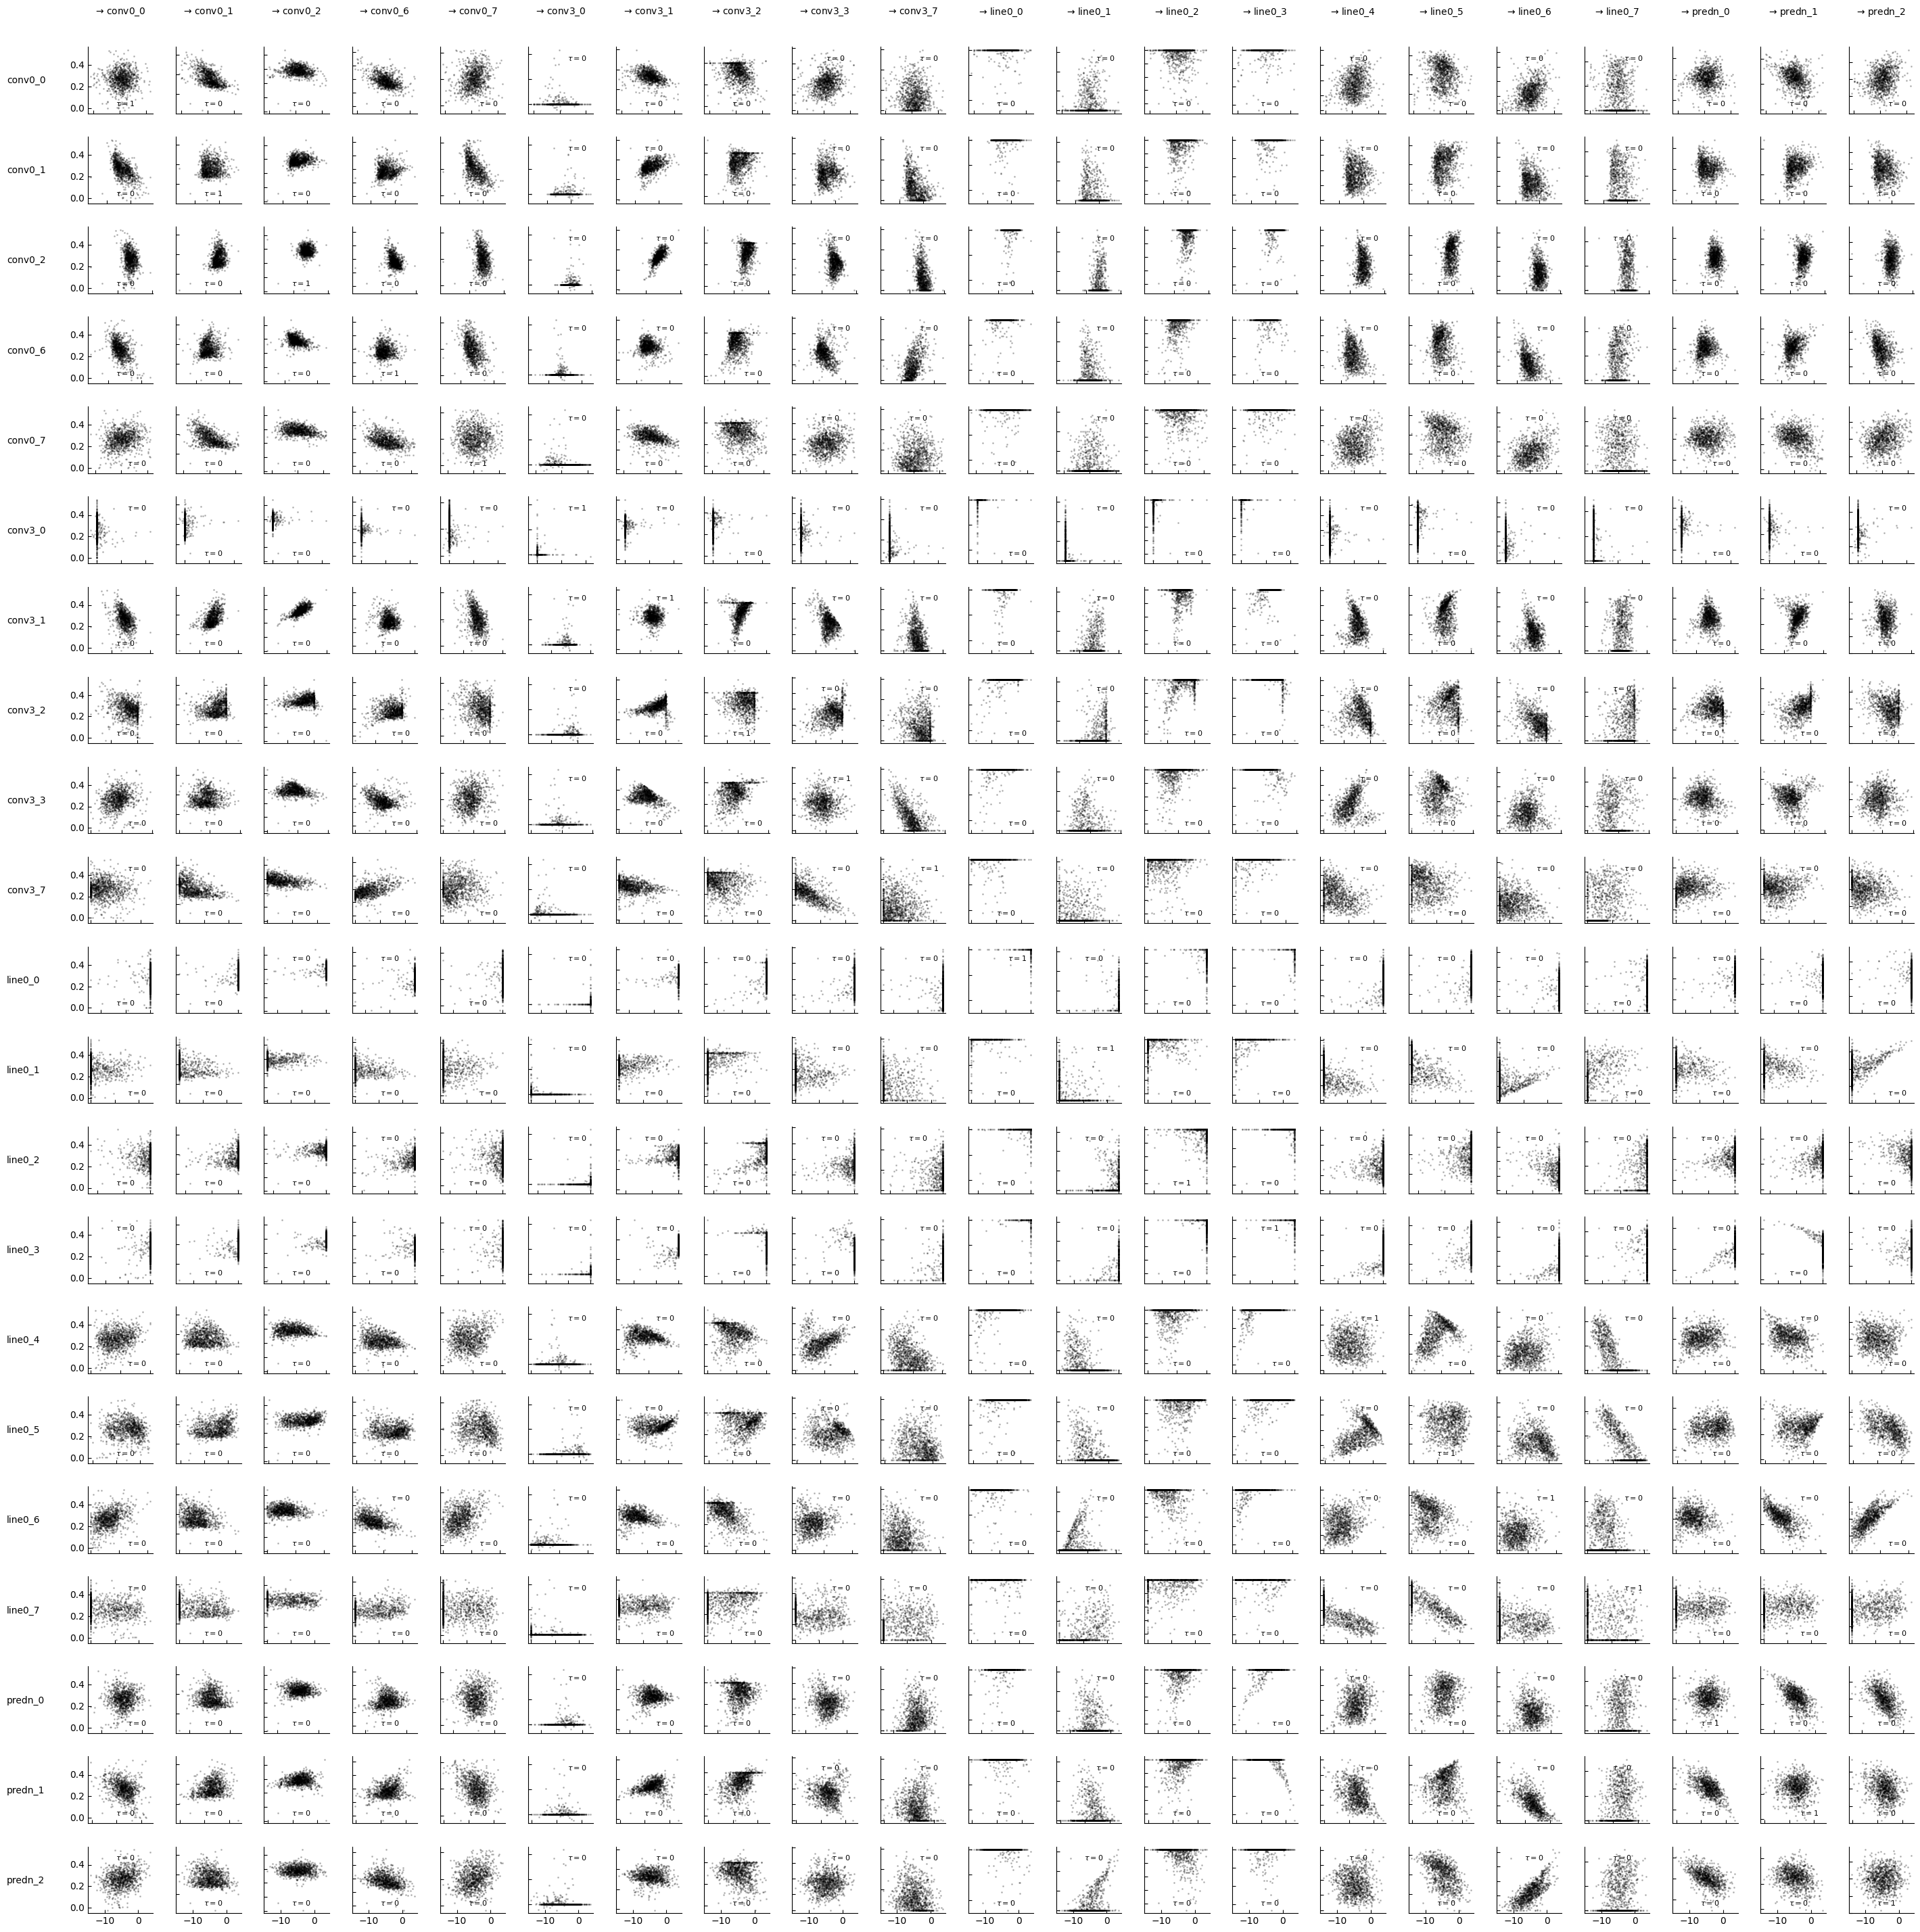

In [193]:

# create different datasets for each layer
#cond_layer = "convolutional_layers.0" #16 neurons
#cond_layer = "convolutional_layers.2" #16 neurons
#cond_layer = "linear_layers.0" #32 neurons
#cond_layer = "linear_layers.2" #10 neurons (the output layer)
#neurons = range(8)  # depending on how many neurons are in the layer
#plot_dataframe,plot_var_names, layers = no_constants_df(layers,0) #create_dataframe(cond_layer, neurons,0)

setup_args = {"figsize": (30,30),"label_space_left": 0.05,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [44]:
# it will take approximately 20 min on a Titan RTX
# run this only if you want to regenerate all the reference images visualizations
saved_files = fv.run(composite, 0, len(dsprites_dataset), 20, 100)

Running Analysis...


100%|██████████| 11060/11060 [07:52<00:00, 23.39it/s]


100%|██████████| 1332/1332 [00:00<00:00, 1381.85it/s]


100%|██████████| 1/1 [00:00<00:00, 120.53it/s]


Nodes:
 [('linear_layers.0', 0), ('convolutional_layers.3', 3), ('convolutional_layers.3', 1), ('convolutional_layers.3', 0), ('convolutional_layers.3', 4), ('convolutional_layers.3', 5), ('convolutional_layers.3', 3), ('convolutional_layers.3', 1), ('convolutional_layers.3', 0), ('convolutional_layers.3', 4), ('convolutional_layers.3', 5), ('convolutional_layers.0', 7), ('convolutional_layers.0', 0), ('convolutional_layers.0', 2), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1), ('convolutional_layers.0', 7), ('convolutional_layers.0', 0), ('convolutional_layers.0', 2), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1), ('convolutional_layers.0', 0), ('convolutional_layers.0', 1)] 
Connections:
 {('linear_layers.0', 0

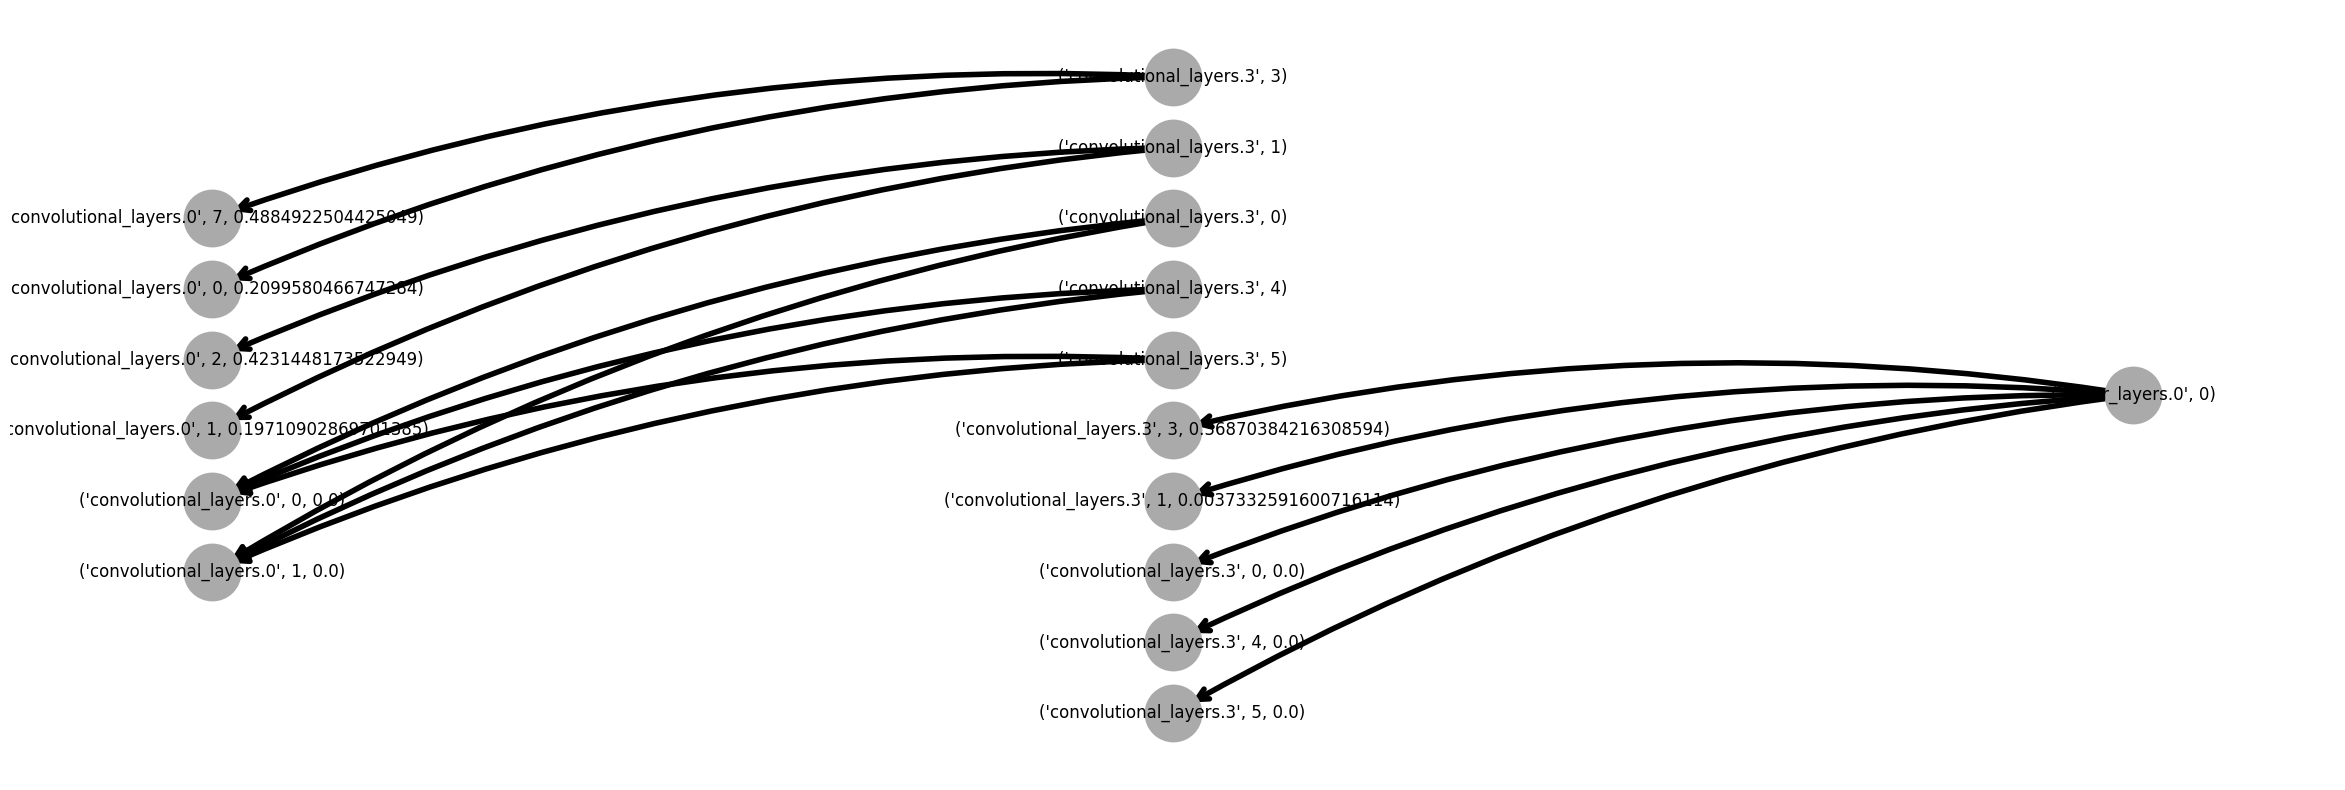

In [240]:
from crp.graph import trace_model_graph
from crp.attribution import AttributionGraph

graph = trace_model_graph(model, sample, layer_names)
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {name: cc for name in layer_names}
attgraph = AttributionGraph(attribution, graph, layer_map)

# decompose concept 71 in features.40 w.r.t. target 46 (lizard class)
# width=[5, 2] returns first the 5 most relevant concepts in the previous lower-level layer
# and in the second iteration returns for each of the 5 most relevant concepts again the two
# most relevant concepts in the previous lower-level layer
nodes, connections = attgraph(sample, composite, 0, "linear_layers.0", 0, width=[5, 2], abs_norm=True)
edges = [i[0] for i in connections]
edge_weights = [i[1] for i in connections]
print("Nodes:\n", nodes, "\nConnections:\n", connections)
G = nx.DiGraph(edges)
print(G.nodes)
i = 0
for n in G.nodes:
    G.nodes[n]["subset"] = nodes[i][0]
    i+=1

pos = nx.multipartite_layout(G, subset_key="subset")
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111, frame_on=False)
nx.draw_networkx(
    G,
    ax=ax,
    pos=pos,
    node_size=1000,
    linewidths=10,
    width=4,
    node_color="#aaaaaa",
    arrowstyle="->",
    arrowsize=20,
    connectionstyle="arc3,rad=0.1",
) 
def make_relevance_graph():
    layers = [["convolutional_layers.0",range(8)], ["convolutional_layers.3",range(8)], ["linear_layers.2",range(8)], ["linear_layers.0", range(3)]]
    nodes = []